In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ai_client
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *
from src.agents.news_filtering_agent import *
from src.agents.trading_agent import *
from src.agents.supervisor_trader import SupervisorTrader
from src.agents.marginal_agent import MarginalAgent
from src.agents.supervisor_margin_trader import SupervisorMarginTrader
from src.news_providers.tradingview_provider import TradingViewProvider
from src.agents.automated_supervised_trader import AutomatedSupervisedTrader

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
coin = "ETH"

cutoff = get_current_datetime()
str(cutoff)

'2024-05-13 02:49:11.190342'

In [54]:
day_12h_history, day_history, week_history = map_async(lambda: get_12h_history(coin), lambda: get_day_history(coin), lambda: get_week_history(coin))

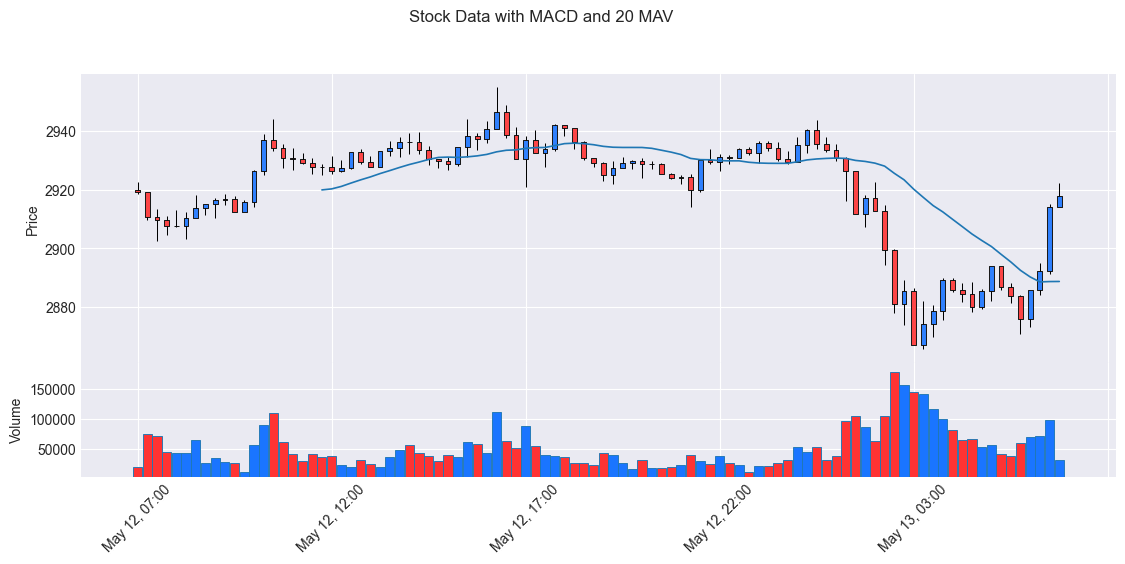

In [58]:
make_candlebars(day_history)

In [59]:
balance = {coin: 0, "USDT": 1000}
operations_history = []

agent = AutomatedSupervisedTrader()

cutoff = subtract_time(get_current_datetime(), days=30)

predict, _, history = agent.decide(coin=coin, balance=balance, cutoff=cutoff)
predict

{'strategy_evaluation': 'The decision to hold makes sense given the unclear market direction and the risk of entering trades that have an equal likelihood of gain and loss. The strategy aims to preserve capital in a volatile or uncertain market environment.',
 'calculations_evaluation': 'The calculations for potential profits and losses in both long and short positions appear consistent and correct. They accurately reflect the potential outcomes with the given stop-loss and take-profit levels.',
 'changes_description': 'No changes are necessary as the approach used is conservative and fits well within the current market analysis.',
 'technical_analysis': 'The stock chart shows a steady decline in price from above 3500 to around 3200 with a short-term stabilization and slight upward correction to current price 3265.25. The Moving Average Convergence Divergence (MACD) and the 20-period moving average (20 MAV) indicate the possibility of a change in momentum, as the MACD is showing diverg

In [67]:
from src.testing.test_runner import TestingEngine
from src.agents.random_predictor import RandomPredictor

agent = RandomPredictor(trade_rate=0.04, tp_ratio=0.3)

engine = TestingEngine(coin="ETH", agent=agent, balance={"usdt": 1000})

engine.test(steps=25)

print(engine.balance)

{'usdt': 973.7177550072922}


In [68]:
engine.logs

['Start step 0',
 "Predict {'final_decision': 'short', 'price': 3256.34, 'stop_loss': 3295.41608, 'take_profit': 3126.0864, 'leverage': '1x', 'amount': 300.0}",
 "balance {'usdt': 700.0}",
 "MATCHED {'kind': 'short', 'take_profit': 3126.0864, 'stop_loss': 3295.41608, 'amount': 300.0, 'price': 3256.34, 't': 1712992425} TP ; tp_diff: 12.0, sl_diff: -3.599999999999983",
 "new balance {'usdt': 1012.0}",
 'Start step 1',
 "Predict {'final_decision': 'short', 'price': 3283.31, 'stop_loss': 3322.70972, 'take_profit': 3151.9775999999997, 'leverage': '1x', 'amount': 303.59999999999997}",
 "balance {'usdt': 708.4000000000001}",
 "MATCHED {'kind': 'short', 'take_profit': 3151.9775999999997, 'stop_loss': 3322.70972, 'amount': 303.59999999999997, 'price': 3283.31, 't': 1713014025} SL ; tp_diff: 12.14400000000002, sl_diff: -3.643199999999989",
 "new balance {'usdt': 1008.3568}",
 'Start step 2',
 "Predict {'final_decision': 'short', 'price': 3219.82, 'stop_loss': 3258.45784, 'take_profit': 3091.0272

In [69]:
from src.testing.test_runner import TestingEngine
from src.agents.random_predictor import RandomPredictor

agent = AutomatedSupervisedTrader()

engine = TestingEngine(coin="ETH", agent=agent, balance={"usdt": 1000})

engine.test(steps=15)

print(engine.balance)

{'usdt': 899.8920140675011}


In [72]:
engine.logs

['Start step 0',
 'Predict {\'strategy_evaluation\': \'The decision to hold makes sense given the recent market stabilization but ongoing bearish trend, avoiding potential losses from entering a trade during a period of uncertainty. This passive approach is suitable until clearer signals emerge.\', \'calculations_evaluation\': \'Calculations for potential profits and losses on long and short positions are correct, assuming an average leverage of 1x and reasonable take-profit and stop-loss thresholds.\', \'changes_description\': \'No changes to the trading strategy are necessary at this time, but continuous monitoring of the market is recommended to adjust to any new trends or signals.\', \'technical_analysis\': \'The chart displays a declining trend highlighted by a 20-period moving average (MAV) that moves downwards throughout most of the observation period. Prices have consistently stayed below the MAV, indicating a bearish trend. Recently, there is a minor stabilization, but the pri

In [73]:
engine.orders

[]